# Variable

## Variable 的数据结构

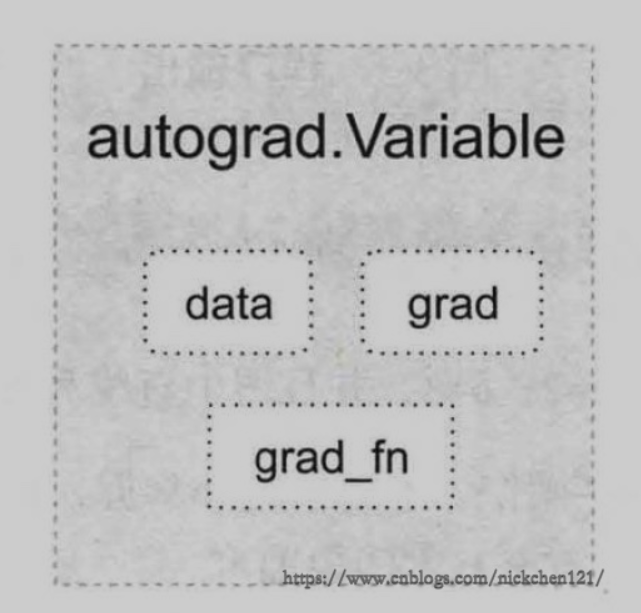

+ 上图主要包含三个属性：
    + data：保存 variable 所包含的 tensor
    + grad：保存 data 对应的梯度，grad 也是 variable，而非 tensor，它与 data 形状一致
    + grad_fn：指向一个 Function，记录 variable 的操作历史，即它是什么操作的输出，用来构建计算图。如果某一变量是用户创建的，则它为叶子节点，对应的 grad_fn 为 None
+ Variable 的构造函数需要传入 tensor，也有两个可选的参数：
    + requires_grad(bool)：是否需要对该 Variable 求导
    + volatile(bool)：设置为 True，构建在该 Variable 之上的图都不会求导

## 反向传播

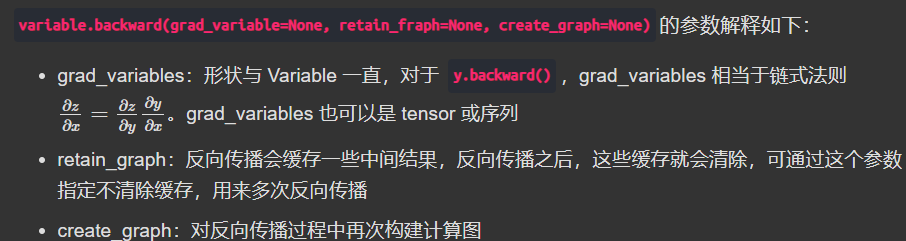

In [9]:
import torch as t
from torch.autograd import Variable as V
a = V(t.ones(3, 4), requires_grad=True)
b = V(t.zeros(3, 4))
c = a.add(b)  # variable 函数的使用和 tensor 一致，等同于 c=a+b

# 注：虽然没有指定 c 需要求导，但 c 依赖于 a，由于 a 需要求导，因此 c 的 requeires_grad 默认设置为 True
a.requires_grad, b.requires_grad, c.requires_grad


(True, False, True)

In [10]:
# 注：`c.data.sum()`是在去 data 后变为 tensor，从 tensor 计算sum；`c.sum()`计算后仍然是 variable
d = c.sum() #'torch.FloatTensor'
d.backward()  # 反向传播
a.grad

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [11]:
# 由用户创建的 Variable 属于叶子节点，对应的 grad_fn 是 None
a.is_leaf, b.is_leaf, c.is_leaf

(True, True, False)

In [12]:
# 虽然 `c.requires_grad=True`，但是它的梯度计算完之后就会被释放
c.retain_grad()  # 对于非叶节点求导，需进行保存，否则会被自动释放，这里我们先保存然后再查看，如果没有这一行，会报错
c.grad is None

True

## autograd 求导数和手动求导数

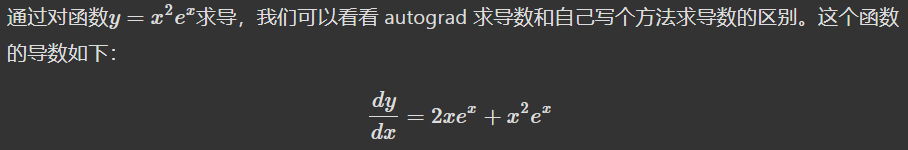

In [13]:
def f(x):
    """计算 y"""
    y = x**2 * t.exp(x)
    return y


def grad_f(x):
    """手动对函数求导"""
    dx = 2 * x * t.exp(x) + x**2 * t.exp(x)
    return dx


x = V(t.randn(3, 4), requires_grad=True)
y = f(x)
y

tensor([[5.1925e-01, 5.1581e-01, 1.8371e-02, 8.5070e-02],
        [6.5862e+01, 2.7681e+00, 9.8252e+00, 1.3417e-02],
        [4.1408e-01, 3.1157e-01, 3.7290e-01, 3.2502e-01]],
       grad_fn=<MulBackward0>)

In [14]:
y_grad_variables = t.ones(y.size())  # 由于dz/dy=1，并且grad_variables 形状需要与 y 一致，详解看下面的 3.4 小节
y.backward(y_grad_variables)
x.grad

tensor([[ -0.1222,  -0.1322,  -0.2336,  -0.4054],
        [120.2930,   8.2710,  23.0232,  -0.2044],
        [ -0.3155,  -0.4159,  -0.3628,  -0.4059]])

In [15]:
grad_f(x)  # autograd 计算的结果和利用公式计算的结果一致

tensor([[ -0.1222,  -0.1322,  -0.2336,  -0.4054],
        [120.2930,   8.2710,  23.0232,  -0.2044],
        [ -0.3155,  -0.4159,  -0.3628,  -0.4059]], grad_fn=<AddBackward0>)

# 计算图

## 利用 torch 进行反向传播求梯度

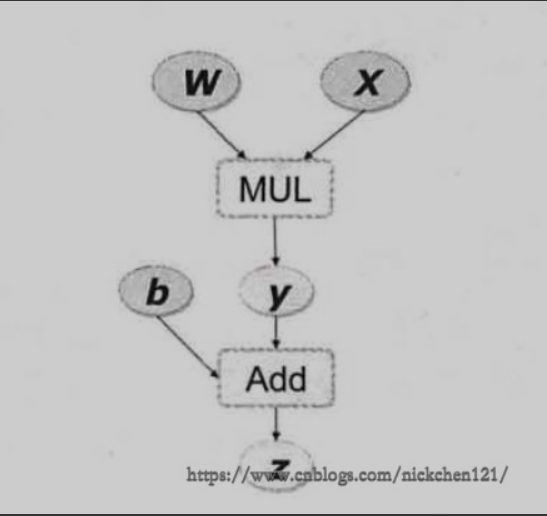

上图是算子(运算符)与变量的关系，我们可以使用torch的autograd反向传播自动完成(如下图)。torch把每个操作写进计算图中，每一个变量在图中的位置可以通过grad_fn属性在图中位置推测得到。

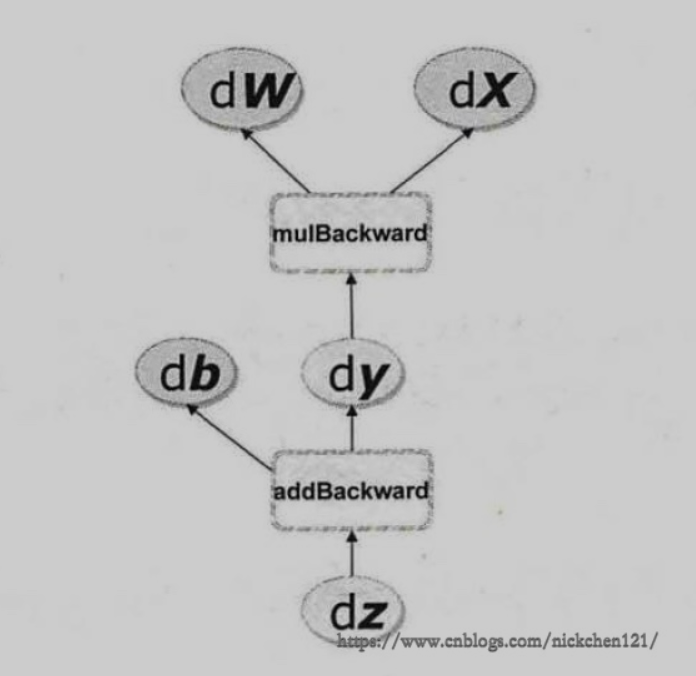

## 在前向传播中利用动态图特性构建计算图
由于 torch 使用的是动态图，它的计算图在每次前向传播开始都是从头开始构建的，因此可以用使用 Python 的控制语句按照需求构建计算图。这意味着你不需要事先构建所有可能用到的图的路径，图可以在运行的时候构建：

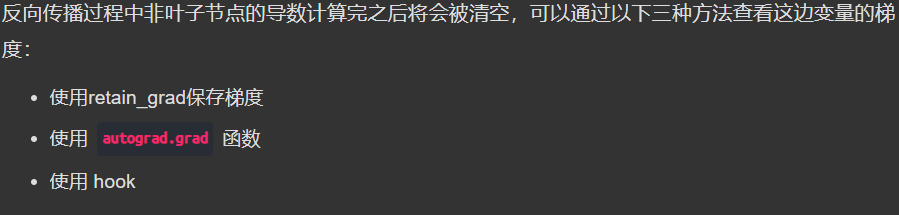

In [21]:
x = V(t.ones(3), requires_grad=True)
w = V(t.rand(3), requires_grad=True)

y = x * w
z = y.sum()

z.backward()
y.retain_grad()#在计算前使用 就会保存梯度
# 非叶子节点grad 计算完后清空，y 是 None
y.grad

In [20]:
# 第一种方法，保存梯度
x = V(t.ones(3), requires_grad=True)
w = V(t.rand(3), requires_grad=True)

y = x * w
z = y.sum()

y.retain_grad()
z.backward()
# 非叶子节点grad 计算完后清空，y 是 None
y.grad


tensor([1., 1., 1.])

In [22]:
# 第二种方法，使用 grad 获取中间变量的梯度
x = V(t.ones(3), requires_grad=True)
w = V(t.rand(3), requires_grad=True)

y = x * w
z = y.sum()

# z 对 y 的梯度，隐式调用 backward()
t.autograd.grad(z, y)

(tensor([1., 1., 1.]),)

In [23]:
# 第三种方法，使用 hook
# hook 是一个函数，输入是梯度，不应该有返回值
def variable_hook(grad):
    print(f'y 的梯度：{grad}')


x = V(t.ones(3), requires_grad=True)
w = V(t.rand(3), requires_grad=True)

y = x * w
z = y.sum()

# 注册 hook
hook_handle = y.register_hook(variable_hook)
z = y.sum()
z.backward()

# 除非你每次都要使用 hook，否则使用后应该移除 hook
hook_handle.remove()

y 的梯度：tensor([1., 1., 1.])


## variable 的 grad 属性和 backward函数 的 grad_variables 参数的区别

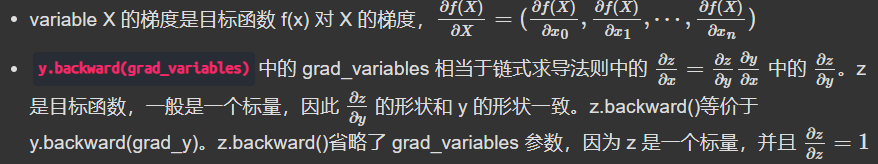

In [24]:
x = V(t.arange(0, 3, dtype=t.float32), requires_grad=True)
y = x**2 + x * 2  # dy/dz = 2 * x + 2
z = y.sum()
z.backward()  # 从 z 开始反向传播
x.grad

tensor([2., 4., 6.])

In [25]:
x = V(t.arange(0, 3, dtype=t.float32), requires_grad=True)
y = x**2 + x * 2  # dy/dz = 2 * x + 2
z = y.sum()
y_grad_variables = V(t.Tensor([1, 1, 1]))  # dz/dy
y.backward(y_grad_variables)
x.grad

tensor([2., 4., 6.])

## 总结
+ torch 中计算图的特点可总结如下：

    + autograd 根据用户对 variable 的操作构建计算图。对 variable 的操作抽象为 Function。
    + 由用户创建的结点称作叶子节点，叶子节点的 grad_fn 为 None。并且叶子节点中需要求导的 variable，具有 AccumulateGrad 标识，因为它的梯度是累加的。
    + variable 默认是不需要求导的。如果某一个节点的 requeires_grad=True，那么所有依赖它的节点都为 True。
    + 多次反向传播时，梯度是累加的。反向传播的中间缓存会被清空，为进行多次反向传播需要指定 retain_graph=True 来保存这些缓存。
    + 非叶子节点的梯度计算完之后就会被清空，可以使用 autograd.grad 和 hook 技术获取非叶子节点梯度的值，也可以通过 retain_grad 保存它的梯度值。
    + varibale 的 grad 和 data 形状一致，应该避免直接修改 variable.data，因为对 data 值的修改无法进行反向传播。
    + 反向传播函数 backward 的参数 grad_variables 可以看成是链式求导的中间结果，如果是标量，可以省略，默认为 1。
    + torch 采用动态图的设计，可以很方便的查看中间层的输出，动态地设计计算图的结构

# 线性回归实战

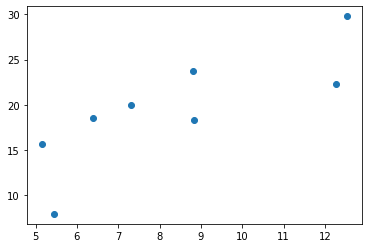

In [35]:
import torch as t
from torch.autograd import Variable as V
# 不是 jupyter 运行请注释掉下面一行，为了 jupyter 显示图片
from matplotlib import pyplot as plt
from IPython import display

t.manual_seed(1000)  # 随机数种子


def get_fake_data(batch_size=8):
    """产生随机数据：y = x * 2 + 3，同时加上了一些噪声"""
    x = t.rand(batch_size, 1) * 20
    y = x * 2 + (1 + t.randn(batch_size, 1)) * 3  # 噪声为 |3-((1 + t.randn(batch_size, 1)) * 3)|

    return x, y


# 查看 x，y 的分布情况
x, y = get_fake_data()
plt.scatter(x.squeeze().numpy(), y.squeeze().numpy())
plt.show()


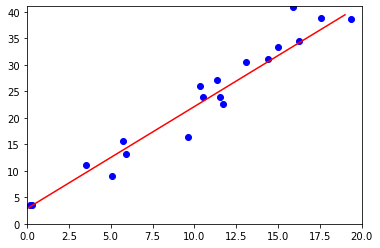

In [38]:
# 随机初始化参数
w = V(t.rand(1, 1), requires_grad=True)
b = V(t.zeros(1, 1), requires_grad=True)

lr = 0.001  # 学习率

for i in range(8000):
    x, y = get_fake_data()
    x, y = V(x), V(y)

    # forwad：计算 loss
    y_pred = x.mm(w) + b.expand_as(y)
    loss = 0.5 * (y_pred - y)**2
    loss = loss.sum()

    # backward：自动计算梯度
    loss.backward()

    # 更新参数
    w.data.sub_(lr * w.grad.data)
    b.data.sub_(lr * b.grad.data)

    # 梯度清零，不清零则会进行叠加，影响下一次梯度计算
    w.grad.data.zero_()
    b.grad.data.zero_()

    if i % 1000 == 0:
        # 画图
        display.clear_output(wait=True)
        x = t.arange(0, 20, dtype=t.float).view(-1, 1)
        y = x.mm(w.data) + b.data.expand_as(x)
        plt.plot(x.numpy(), y.numpy(), color='red')  # 预测效果

        x2, y2 = get_fake_data(batch_size=20)
        plt.scatter(x2.numpy(), y2.numpy(), color='blue')  # 真实数据

        plt.xlim(0, 20)
        plt.ylim(0, 41)
        plt.show()
        plt.pause(0.5)
#         break  # 注销这一行，可以看到动态效果


In [28]:
# y = x * 2 + 3
w.data.squeeze(), b.data.squeeze()  # 打印训练好的 w 和 b

(tensor(2.3009), tensor(0.1634))